In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.stats import poisson
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [4]:
# Reading channels
data = Data[1]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [5]:
# Para el caso 1 canal
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [6]:
def Gauss(x,mean=1.,sigma=0.2):
    return norm.pdf(x,loc=mean,scale=sigma)

In [7]:
def Poisson(n,l):
    return poisson.pmf(n,mu=l)

In [8]:
Poisson(5,4)

0.1562934518505317

In [9]:
def Poisson1(n,l):

    if l > 0.:
        log_likelihood = -l + n*np.log(l) - gammaln(n+1)  # Softening parameter
        return np.exp(log_likelihood)
    else:
        return 0.

In [10]:
Poisson1(5,1)

0.00306566200976202

In [11]:
def Likelihood(p,sigma,n,b,s):

    mu,e = p
    l = mu*s+e*b
    
    return Poisson1(n,l)*Gauss(e,1.,sigma=sigma)

In [12]:
# Probando la funcion de likelihood
Likelihood(np.array([0.4,1.]),0.1,n[0],b[0],s[0])

0.15445412480195864

In [13]:
def GetJointLikelihood(p,sigma,n,b,s):

    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(p,sigma,n[c],b[c],s[c]))

    return JointLike

In [14]:
GetJointLikelihood(np.array([0.4,1.]),0.1,n,b,s)

3.7357163071680115

In [15]:
mu = np.linspace(0.1,3,30)
e = np.linspace(0.5,1.5,30)
Mu,E = np.meshgrid(mu,e)
Surface = np.zeros_like(Mu)
# Background error
sigma = 0.1

for i in range(len(mu)):
    for j in range(len(e)):
        like = GetJointLikelihood(np.array([mu[i],e[j]]),sigma,n,b,s)
        Surface[i,j] = like

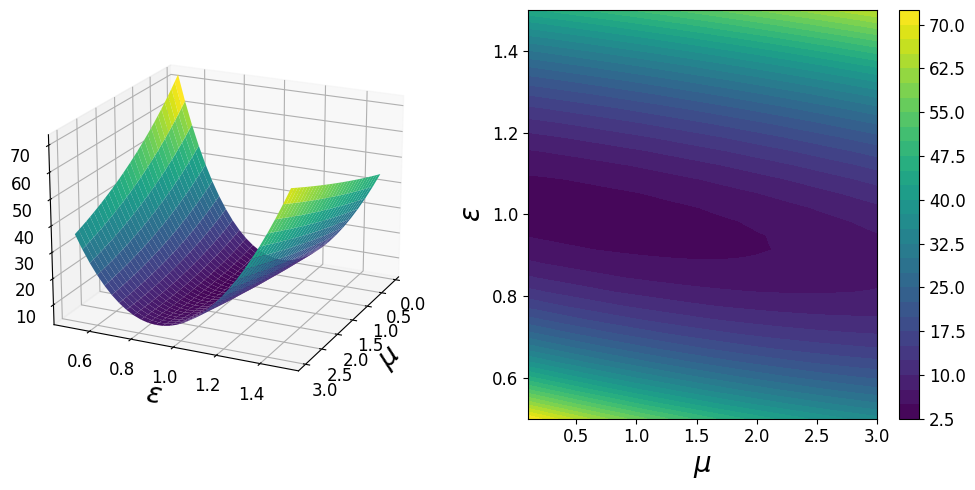

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, projection='3d', elev = 20, azim = 25)
ax.plot_surface(Mu,E,Surface.T, cmap='viridis')
ax1 = fig.add_subplot(1,2,2)
c = ax1.contourf(Mu,E,Surface.T,30,cmap='viridis')
fig.colorbar(c,ax=ax1)

ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\epsilon$')

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$\epsilon$')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
#ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')
#
plt.savefig('ProfileLikeRatio.pdf')

In [17]:
def GetJointLikelihoodNuissance(p,mu,sigma,n,b,s):

    e = p[0]
    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(np.array([mu,e]),sigma,n[c],b[c],s[c]))

    return JointLike

In [18]:
GetJointLikelihoodNuissance(np.array([1.]),1.,0.1,n,b,s)

3.956928310448823

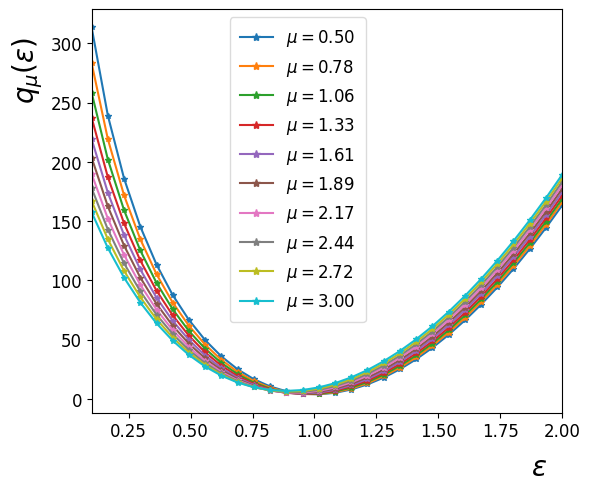

In [19]:
mu = 1.0
sigma = 0.1

mu = np.linspace(0.5,3.,10)
e = np.linspace(0.1,2,30)
perfil = np.zeros((mu.shape[0],e.shape[0]))

for i in range(len(mu)):
    for j in range(len(e)):
        perfil[i,j] = GetJointLikelihoodNuissance(np.array([e[j]]),mu[i],sigma,n,b,s)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(len(mu)):
    ax.plot(e,perfil[i,:],marker='*',label=r'$\mu= %.2f$'%(mu[i]))

# Label X
ax.set_xlabel(r'$\epsilon$')
ax.xaxis.set_label_coords(0.95,-0.1)
ax.set_xlim(e[0],e[-1])

# Label Y
ax.set_ylabel(r'$q_{\mu}(\epsilon)$')
ax.yaxis.set_label_coords(-0.1,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(0.6,1),ncol=1,title='')

#
plt.savefig('NuissanceProfile.pdf')

In [20]:
def GetHat(n,b,s,sigma=0.1):

    bounds = ((0,50),(0,10))
    p0 = np.array([1.,1.])
    result = spo.minimize( GetJointLikelihood, p0, args=(sigma,n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Hat = result.x

    return Hat

In [21]:
def GetDoubleHat(mu,sigma,n,b,s):
    
    bounds =  ((0,10),)
    p0 = np.array([1.])
    result = spo.minimize( GetJointLikelihoodNuissance, p0, args=(mu,sigma,n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Doublehat = result.x[0]

    return Doublehat

In [22]:
sigma = 0.1
GetHat(n,b,s,sigma)

array([0.49996987, 1.00000148])

In [23]:
GetDoubleHat(1.0,sigma,n,b,s)

0.9758789062500001

In [24]:
# Estimador estadístico

def GetqmObs(mu,sigma,n,b,s):

    doublehat = GetDoubleHat(mu,sigma,n,b,s)
    hat = GetHat(n,b,s,sigma)
    
    qm = 0.
    
    for c in range(N):
        
        if mu > hat[0]:
            qm += -2*np.log( Likelihood(np.array([mu,doublehat]),sigma,n[c],b[c],s[c]) / Likelihood(hat,sigma,n[c],b[c],s[c]) ) 
            
    return qm

In [25]:
# Observed
qmObs = GetqmObs(1.2,sigma=0.1,n=n,b=b,s=s)
qmObs

0.23624002128064142

In [26]:
# Expected
qmObsE = GetqmObs(1.2,sigma=0.1,n=b,b=b,s=s)
qmObsE

0.7056077651675925

In [27]:
mu = np.linspace(0.1,6.0,20)
qmObsEV = np.zeros_like(mu)
qmObsEV1 = np.zeros_like(mu)
qmObsEV2 = np.zeros_like(mu)

for i in range(mu.shape[0]):
    qmObsEV[i] = GetqmObs(mu[i],sigma=0.05,n=n,b=b,s=s)
    qmObsEV1[i] = GetqmObs(mu[i],sigma=0.1,n=n,b=b,s=s)
    qmObsEV2[i] = GetqmObs(mu[i],sigma=0.2,n=n,b=b,s=s)

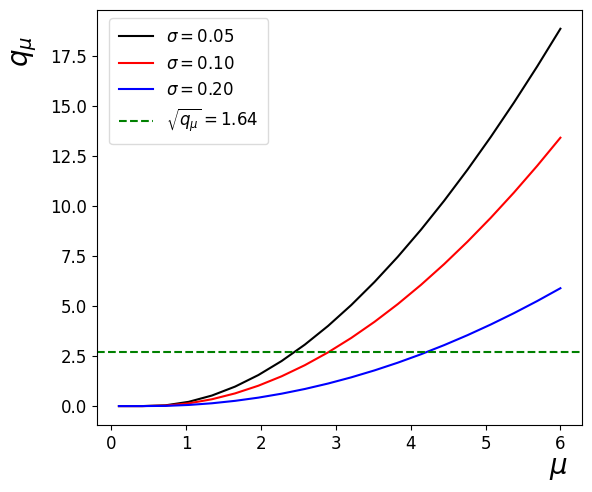

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mu,qmObsEV,color='k',label=r'$\sigma=$%.2f'%(0.05))
ax.plot(mu,qmObsEV1,color='r',label=r'$\sigma=$%.2f'%(0.1))
ax.plot(mu,qmObsEV2,color='b',label=r'$\sigma=$%.2f'%(0.2))

ax.axhline(y=norm.ppf(0.95)**2,ls='--',color='g',label=r'$\sqrt{q_{\mu}}=1.64$')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$q_{\mu}$')
ax.yaxis.set_label_coords(-0.12,0.90)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(0.37,1),ncol=1,title='')


#
plt.savefig('qm_plot_systematic.pdf')